In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import re
import torch
import numpy as np
from matchers import constant, dataset, metrics, utils
from matchers.models.autoencoder import AutoEncoder, train_model

In [4]:
MAX_NAME_LENGTH = 30

### Load data

In [5]:
train, test = dataset.load_process_from_disk()

input_names_train, weighted_relevant_names_train, candidates_train = train
input_names_test, weighted_relevant_names_test, candidates_test = test

relevant_names_train = [[name for name, _, _ in name_weights] for name_weights in weighted_relevant_names_train]
relevant_names_test = [[name for name, _, _ in name_weights] for name_weights in weighted_relevant_names_test]

all_candidates = np.concatenate((candidates_train, candidates_test))

### Load all names

In [6]:
min_name_count = 5

In [7]:
def load_names(filename):
    names = []
    with open(filename, mode="r", encoding="utf-8") as f:
        for line in f:
            fields = line.rstrip().split("\t")
            name = fields[0]
            count = int(fields[1])
            if count >= min_name_count:
                name = re.sub("[.' ]", '', name)
                names.append(utils.add_padding(name))
    return names

In [8]:
all_names = load_names('../data/given-final.normal.txt') + load_names('../data/surname-final.normal.txt')
print(len(all_names))

606072


### Build token index mappings

In [6]:
char_to_idx_map, idx_to_char_map = utils.build_token_idx_maps()

### Convert names to ids

In [10]:
# Prepare data for training
# inputs and targets have the same data just in different representations 1-hot vs normal sequences
X_train_inputs, X_train_targets = utils.convert_names_model_inputs(all_names, 
                                                                   char_to_idx_map, 
                                                                   MAX_NAME_LENGTH)

In [11]:
print(X_train_inputs.shape, X_train_targets.shape)

torch.Size([606072, 30, 29]) torch.Size([606072, 30])


### Model

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [13]:
model = AutoEncoder(input_size=constant.VOCAB_SIZE + 1, 
                    hidden_size=100,
                    num_layers=1,
                    seq_len=MAX_NAME_LENGTH,
                    device=device)

In [14]:
train_model(model, X_train_inputs, X_train_targets, 100, 512)

100%|██████████| 100/100 [2:49:07<00:00, 101.47s/it, loss=1.52e-5]  


In [16]:
torch.save(model, '../data/ae-bilstm-100.pth')

In [7]:
model = torch.load('../data/ae-bilstm-100.pth')

### Understand AutoEncoder

In [17]:
loss_fn = torch.nn.CrossEntropyLoss()
dataset_train = torch.utils.data.TensorDataset(X_train_inputs, X_train_targets)
data_loader = torch.utils.data.DataLoader(dataset_train, batch_size=512, shuffle=True)

In [18]:
train_batch, labels_batch = next(iter(data_loader))
print(train_batch.shape, labels_batch.shape)

torch.Size([512, 30, 29]) torch.Size([512, 30])


In [19]:
model.zero_grad()
# Encode(input,hidden) -> (batch,seq,dirs*hidden), ((dirs*layers,batch,hidden),(dirs*layers,batch,hidden)) - x_encoded is the last hidden state
_, (x_encoded, _) = model.lstm_encoder(train_batch.to(device))
print(x_encoded.shape)

torch.Size([2, 512, 100])


In [20]:
# Concatenate left-right hidden vectors
x_encoded = torch.cat([x_encoded[0], x_encoded[1]], dim=1)
print(x_encoded.shape)

torch.Size([512, 200])


In [21]:
# Reshape data to have seq_len time steps
# why do we copy x_encoded to every time step?
x_encoded = x_encoded.unsqueeze(1).repeat(1, MAX_NAME_LENGTH, 1)
print(x_encoded.shape)

torch.Size([512, 30, 200])


In [22]:
# Decode(hidden*dirs,hidden) -> (batch,seq,dirs*hidden), ((dirs*layers,batch,hidden),(dirs*layers,batch,hidden)) - x_decoded is the output
x_decoded, (_, _) = model.lstm_decoder(x_encoded)
print(x_decoded.shape)

torch.Size([512, 30, 100])


In [23]:
# linear layer(hidden,input) predicts characters
x_prime = model.linear(x_decoded)
print(x_prime.shape)

torch.Size([512, 30, 29])


In [24]:
# Reshape output to match CrossEntropyLoss input
x_prime = x_prime.transpose(1, -1)
print(x_prime.shape)

torch.Size([512, 29, 30])


In [25]:
# Compute loss (batch,classes,seq), (batch,seq)
loss = loss_fn(x_prime, labels_batch.to(device))
print(loss)

tensor(2.9429e-05, device='cuda:0', grad_fn=<NllLoss2DBackward>)


### Evaluation

In [8]:
model.to("cpu")
model.device="cpu"

In [9]:
# Convert train name inputs to correct format
X_train_inputs, _ = utils.convert_names_model_inputs(candidates_train,
                                                     char_to_idx_map, 
                                                     MAX_NAME_LENGTH)
# Get Embeddings for the names from the encoder
X_train_candidates_encoded = model(X_train_inputs, just_encoder=True).detach().numpy()

In [10]:
print(X_train_inputs.shape)
print(X_train_candidates_encoded.shape)

torch.Size([22107, 30, 29])
(22107, 200)


In [11]:
# Convert test name inputs to correct format
X_test_inputs, X_test_targets = utils.convert_names_model_inputs(input_names_test,
                                                                 char_to_idx_map, 
                                                                 MAX_NAME_LENGTH)
# Get Embeddings for the names from the encoder
X_input_names_encoded = model(X_test_inputs, just_encoder=True).detach().numpy()

In [12]:
print(X_test_inputs.shape, X_test_targets.shape)
print(X_input_names_encoded.shape)

torch.Size([2444, 30, 29]) torch.Size([2444, 30])
(2444, 200)


In [13]:
# Get embeddings for all candidate names (train + test)
X_test_candidate_inputs, _ = utils.convert_names_model_inputs(candidates_test, 
                                                              char_to_idx_map, 
                                                              MAX_NAME_LENGTH)
X_test_candidates_encoded = model(X_test_candidate_inputs, just_encoder=True).detach().numpy()

In [14]:
print(X_test_candidate_inputs.shape)
print(X_test_candidates_encoded.shape)

torch.Size([2453, 30, 29])
(2453, 200)


In [15]:
X_candidates_encoded = np.vstack((X_train_candidates_encoded, X_test_candidates_encoded))

In [16]:
print(X_candidates_encoded.shape)

(24560, 200)


In [17]:
k = 100
candidates = utils.get_candidates_batch(X_input_names_encoded, 
                                        X_candidates_encoded, 
                                        all_candidates,
                                        num_candidates=k)
print(candidates.shape)
print(candidates[0,0,0])
print(candidates[0,0,1])

(2444, 100, 2)
<abadusky>
0.9095762857505686


In [18]:
candidate_names = candidates[:, :, 0]
print(candidate_names.shape)

(2444, 100)


### Evaluation

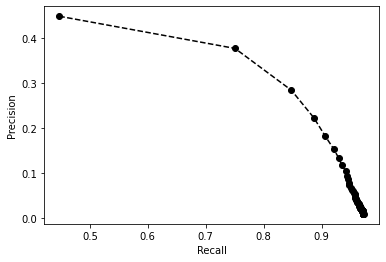

In [19]:
metrics.precision_recall_curve(relevant_names_test, candidate_names, k)

### mAP @ 1

In [20]:
metrics.mean_avg_precision_k(relevant_names_test, candidate_names, 1)

0.44844517184942717

### mAP @ 3

In [21]:
metrics.mean_avg_precision_k(relevant_names_test, candidate_names, 3)

0.36990816512093105

### Demo

In [46]:
test_name = ['<schumacher>']
test_name, _ = utils.convert_names_model_inputs(test_name, char_to_idx_map, MAX_NAME_LENGTH)
test_name_embedding = model(test_name, just_encoder=True).detach().numpy()

utils.get_candidates_batch(test_name_embedding, 
                           X_candidates_encoded,
                           all_candidates,
                           num_candidates=10)

array([[['<schumacker>', 0.9746154770537481],
        ['<schumaker>', 0.9323621066351657],
        ['<stelmacher>', 0.9086041117971908],
        ['<schmelcher>', 0.8968587091091864],
        ['<schmicker>', 0.8843006593922649],
        ['<standacher>', 0.8750426195822874],
        ['<schlicker>', 0.8729185370395702],
        ['<steinacher>', 0.8703248354862012],
        ['<schlecter>', 0.8682462372974001],
        ['<schoenbachler>', 0.8622889207171189]]], dtype=object)

## Evaluate using weighted relevant names and score thresholds

### Avearge precision at 0.97

In [22]:
metrics.avg_precision_at_threshold(weighted_relevant_names_test, candidates, 0.81)

0.14052854834915468

### Average recall at 0.97

In [23]:
metrics.avg_recall_at_threshold(weighted_relevant_names_test, candidates, 0.81)

0.9447626841243862

### PR Curve

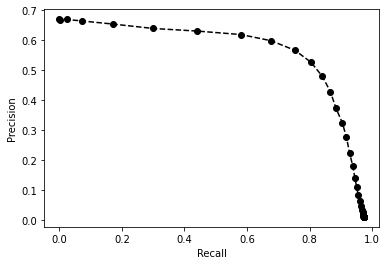

In [24]:
# minimum score threshold to test
min_threshold = 0.5
metrics.precision_recall_curve_at_threshold(weighted_relevant_names_test, candidates, min_threshold)

### AUC

In [27]:
metrics.get_auc(weighted_relevant_names_test, candidates)

0.5610302933856371